In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import concurrent.futures


plt.style.use('ggplot')

# Initialize RoBERTa tokenizer and model
roberta_model_name = "roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)

# Load BERT model and tokenizer
bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name)

# Load GPT-3 model and tokenizer
gpt3_model_name = "gpt2"
gpt3_tokenizer = AutoTokenizer.from_pretrained(gpt3_model_name)
gpt3_model = AutoModelForSequenceClassification.from_pretrained(gpt3_model_name)

df = pd.read_csv(r'C:\Users\GARVITA\Downloads\hatespeech\labeled_data.csv')
df['tweet'] = df['tweet'].astype(str)

print(df.shape)


In [ ]:
df = df.head(2500)
sia = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment scores for a batch of tweets
def calculate_scores(batch):
    res = {}
    for i, text in enumerate(batch):
        try:
            # Calculate VADER sentiment scores
            vader_result = sia.polarity_scores(text)
            vader_result_rename = {}
            for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value

            # Calculate RoBERTa sentiment scores
            encoded_text = roberta_tokenizer(text, return_tensors='pt')
            output = roberta_model(**encoded_text)
            scores = output.logits
            scores = softmax(scores.detach().numpy(), axis=1)
            roberta_result = {
                'roberta_neg': scores[0, 0].item(),
                'roberta_pos': scores[0, 1].item(),
            }

            # Calculate BERT sentiment scores
            encoded_text_bert = bert_tokenizer(text, return_tensors='pt')
            output_bert = bert_model(**encoded_text_bert)
            scores_bert = output_bert.logits
            scores_bert = softmax(scores_bert.detach().numpy(), axis=1)
            bert_result = {
                'bert_neg': scores_bert[0, 0].item(),
                'bert_pos': scores_bert[0, 1].item(),
            }

            # Calculate GPT-3 sentiment scores
            encoded_text_gpt3 = gpt3_tokenizer(text, return_tensors='pt')
            output_gpt3 = gpt3_model(**encoded_text_gpt3)
            scores_gpt3 = output_gpt3.logits
            scores_gpt3 = softmax(scores_gpt3.detach().numpy(), axis=1)
            gpt3_result = {
                'gpt3_neg': scores_gpt3[0, 0].item(),
                'gpt3_pos': scores_gpt3[0, 1].item(),
            }

            # Combine all results
            all_results = {**vader_result_rename, **roberta_result, **bert_result, **gpt3_result}
            res[i] = all_results
        except RuntimeError:
            print(f'Broke for id {i}')
    return res

# Split the dataset into smaller batches
batch_size = 100
batches = [df[i:i + batch_size]['tweet'].tolist() for i in range(0, len(df), batch_size)]

# Process batches in parallel
results = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(calculate_scores, batches), total=len(batches)))

# Combine results from different batches
final_results = {}
for batch_result in results:
    final_results.update(batch_result)

# Create a DataFrame from the results
results_df = pd.DataFrame(final_results).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})

# Merge the results DataFrame with the original DataFrame
results_df = results_df.merge(df, how='left')

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                   'roberta_neg', 'roberta_pos',
                   'bert_neg', 'bert_pos',
                   'gpt3_neg', 'gpt3_pos'],
             hue='class', palette='tab10')
plt.show()

In [ ]:
vader_columns = ['vader_neg', 'vader_pos']
roberta_columns = ['roberta_neg', 'roberta_pos']
bert_columns = ['bert_neg', 'bert_pos']
gpt3_columns = ['gpt3_neg', 'gpt3_pos']

vader_scores = results_df[vader_columns].mean()
roberta_scores = results_df[roberta_columns].mean()
bert_scores = results_df[bert_columns].mean()
gpt3_scores = results_df[gpt3_columns].mean()

# Display the average scores
print("Average Sentiment Scores:")
print("VADER - Negative:", vader_scores['vader_neg'])
print("VADER - Positive:", vader_scores['vader_pos'])
print("RoBERTa - Negative:", roberta_scores['roberta_neg'])
print("RoBERTa - Positive:", roberta_scores['roberta_pos'])
print("BERT - Negative:", bert_scores['bert_neg'])
print("BERT - Positive:", bert_scores['bert_pos'])
print("GPT-3 - Negative:", gpt3_scores['gpt3_neg'])
print("GPT-3 - Positive:", gpt3_scores['gpt3_pos'])


In [ ]:
#create own data. embed this data. predictability 0 to 1. figure out hate speech. precision recall, f1 score. 2 at least algorithms.

# synthetic data and ML techniques on it

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

data= pd.read_csv(r"C:\Users\GARVITA\Downloads\senti_twit\Twitter_Data.csv")
data.columns

In [ ]:
data=data.dropna()

In [ ]:
print(data.isna().sum())

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
max_words = 10000  # Maximum number of words to tokenize
max_sequence_length = 100  # Maximum length of each sequence

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['clean_text'])
X = tokenizer.texts_to_sequences(data['clean_text'])
X = pad_sequences(X, maxlen=max_sequence_length)

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['category'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, 64, input_length=max_sequence_length),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
rnn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print(f'RNN Test Accuracy: {rnn_accuracy}')


In [ ]:
cnn_model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(max_words, 64, input_length=max_sequence_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])


In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
cnn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'CNN Test Accuracy: {cnn_accuracy}')


# hugging face dataset

#https://huggingface.co/datasets/christinacdl/Offensive_Twitter_Dataset

In [1]:
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, GlobalMaxPooling1D
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report

In [2]:

# Load data from JSON files
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    texts = [item['text'] for item in data]
    labels = [item['label'] for item in data]
    return texts, labels

def remove_personal_pronouns(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Load and preprocess data
train_texts, train_labels = load_data(r'D:\twitter_dataset\train.json')
test_texts, test_labels = load_data(r'D:\twitter_dataset\test.json')
val_texts, val_labels = load_data(r'D:\twitter_dataset\validation.json')

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

train_texts = [remove_personal_pronouns(text) for text in train_texts]
test_texts = [remove_personal_pronouns(text) for text in test_texts]
val_texts = [remove_personal_pronouns(text) for text in val_texts]

# Tokenize and pad the text data
max_words = 10000  # Maximum number of words to tokenize
max_sequence_length = 100  # Maximum sequence length (you can adjust this)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)
val_data = pad_sequences(val_sequences, maxlen=max_sequence_length)

# Build a simple CNN model
cnn_model_extended = Sequential([
    Embedding(max_words, 128, input_length=max_sequence_length),
    Conv1D(128, 5, activation='relu', padding='same'),
    MaxPooling1D(5, padding='same'),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the CNN model
cnn_model_extended.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model_extended.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10, batch_size=64)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model_extended.evaluate(test_data, test_labels)
print(f"CNN Test Accuracy: {cnn_accuracy}")

# Calculate predictions for the test data
cnn_predictions = cnn_model_extended.predict(test_data)

# Apply a threshold to convert predictions to binary values
threshold = 0.5
cnn_predictions_binary = (cnn_predictions >= threshold).astype(int)

# Print the classification report
report = classification_report(test_labels, cnn_predictions_binary)
print("CNN Classification Report:\n", report)


Epoch 1/10
1010/1010 [==============================] - 57s 54ms/step - loss: 0.2930 - accuracy: 0.8727 - val_loss: 0.2621 - val_accuracy: 0.8959
Epoch 2/10
1010/1010 [==============================] - 54s 54ms/step - loss: 0.1576 - accuracy: 0.9400 - val_loss: 0.2185 - val_accuracy: 0.9179
Epoch 3/10
1010/1010 [==============================] - 51s 51ms/step - loss: 0.0664 - accuracy: 0.9772 - val_loss: 0.2530 - val_accuracy: 0.9266
Epoch 4/10
1010/1010 [==============================] - 51s 51ms/step - loss: 0.0345 - accuracy: 0.9883 - val_loss: 0.3559 - val_accuracy: 0.9313
Epoch 5/10
1010/1010 [==============================] - 51s 51ms/step - loss: 0.0239 - accuracy: 0.9925 - val_loss: 0.3257 - val_accuracy: 0.9260
Epoch 6/10
1010/1010 [==============================] - 53s 53ms/step - loss: 0.0178 - accuracy: 0.9941 - val_loss: 0.4268 - val_accuracy: 0.9293
Epoch 7/10
1010/1010 [==============================] - 55s 55ms/step - loss: 0.0173 - accuracy: 0.9939 - val_loss: 0.4517 -

In [3]:
# Build a simple RNN model
rnn_model = Sequential([
    tf.keras.layers.Embedding(max_words, 128, input_length=max_sequence_length),
    tf.keras.layers.LSTM(128, return_sequences=True),  # Return sequences for stacking layers
    tf.keras.layers.Dropout(0.2),  # Add dropout for regularization
    tf.keras.layers.LSTM(64, return_sequences=True),   # Another LSTM layer
    tf.keras.layers.GlobalMaxPooling1D(),  # Global max-pooling layer
    tf.keras.layers.Dense(64, activation='relu'),  # Dense layer with ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Compile the RNN model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the RNN model
rnn_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=5, batch_size=64)

# Evaluate the RNN model
rnn_loss, rnn_accuracy = rnn_model.evaluate(test_data, test_labels)
print(f"RNN Test Accuracy: {rnn_accuracy}")
rnn_predictions = rnn_model.predict(test_data)
# Calculate predictions for the RNN model
rnn_predictions = rnn_model.predict(test_data)

# Apply a threshold to convert predictions to binary values
threshold = 0.5
rnn_predictions_binary = (rnn_predictions >= threshold).astype(int)

# Print the classification report
report = classification_report(test_labels, rnn_predictions_binary)
print("Classification Report:\n", report)



Epoch 1/5
1010/1010 [==============================] - 349s 332ms/step - loss: 0.3132 - accuracy: 0.8595 - val_loss: 0.2681 - val_accuracy: 0.8839
Epoch 2/5
1010/1010 [==============================] - 339s 336ms/step - loss: 0.2161 - accuracy: 0.9116 - val_loss: 0.2527 - val_accuracy: 0.8983
Epoch 3/5
1010/1010 [==============================] - 338s 334ms/step - loss: 0.1621 - accuracy: 0.9382 - val_loss: 0.2469 - val_accuracy: 0.9079
Epoch 4/5
1010/1010 [==============================] - 338s 335ms/step - loss: 0.1154 - accuracy: 0.9575 - val_loss: 0.2564 - val_accuracy: 0.9147
Epoch 5/5
149/149 [==============================] - 10s 69ms/step - loss: 0.5754 - accuracy: 0.8506
RNN Test Accuracy: 0.8506425023078918
149/149 [==============================] - 10s 65ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      3427
           1       0.75      0.70      0.72      1320

    accuracy                

In [8]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_sequence_length = 100

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=5, batch_size=32)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_accuracy}")
biLSTM_predictions = model.predict(test_data)

# Apply a threshold to convert predictions to binary values
threshold = 0.5
biLSTM_predictions_binary = (biLSTM_predictions >= threshold).astype(int)

# Print the classification report
report = classification_report(test_labels, biLSTM_predictions_binary)
print("Classification Report:\n", report)



Epoch 1/5
2019/2019 [==============================] - 359s 174ms/step - loss: 0.2991 - accuracy: 0.8708 - val_loss: 0.2685 - val_accuracy: 0.8879
Epoch 2/5
2019/2019 [==============================] - 356s 177ms/step - loss: 0.2058 - accuracy: 0.9152 - val_loss: 0.2459 - val_accuracy: 0.9023
Epoch 3/5
2019/2019 [==============================] - 352s 174ms/step - loss: 0.1438 - accuracy: 0.9424 - val_loss: 0.2490 - val_accuracy: 0.9070
Epoch 4/5
2019/2019 [==============================] - 494s 245ms/step - loss: 0.0968 - accuracy: 0.9634 - val_loss: 0.2590 - val_accuracy: 0.9183
Epoch 5/5
149/149 [==============================] - 10s 66ms/step - loss: 0.5869 - accuracy: 0.8334
Test Accuracy: 0.8333684206008911
149/149 [==============================] - 13s 65ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3427
           1       0.68      0.74      0.71      1320

    accuracy                    

In [7]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer 

# Convert text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=max_words)
train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
test_tfidf = tfidf_vectorizer.transform(test_texts)

# Initialize and train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_classifier.fit(train_tfidf, train_labels)

# Make predictions
xgb_predictions = xgb_classifier.predict(test_tfidf)

# Evaluate the XGBoost model
xgb_accuracy = np.mean(xgb_predictions == test_labels)
print(f"XGBoost Accuracy: {xgb_accuracy}")
xgb_predictions = xgb_classifier.predict(test_tfidf)

# Print the classification report
report = classification_report(test_labels, xgb_predictions)
print("Classification Report:\n", report)


XGBoost Accuracy: 0.8780282283547504
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      3427
           1       0.86      0.67      0.75      1320

    accuracy                           0.88      4747
   macro avg       0.87      0.81      0.84      4747
weighted avg       0.88      0.88      0.87      4747



In [6]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have already loaded and preprocessed your data

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features as needed

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_texts)
y_train = np.array(train_labels)

# Transform the test data
X_test = tfidf_vectorizer.transform(test_texts)
y_test = np.array(test_labels)

# Create and train an SVM model
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

# You can also generate a classification report for more detailed metrics
print(classification_report(y_test, y_pred))


Test Accuracy: 0.88961449336423
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3427
           1       0.82      0.77      0.80      1320

    accuracy                           0.89      4747
   macro avg       0.87      0.85      0.86      4747
weighted avg       0.89      0.89      0.89      4747



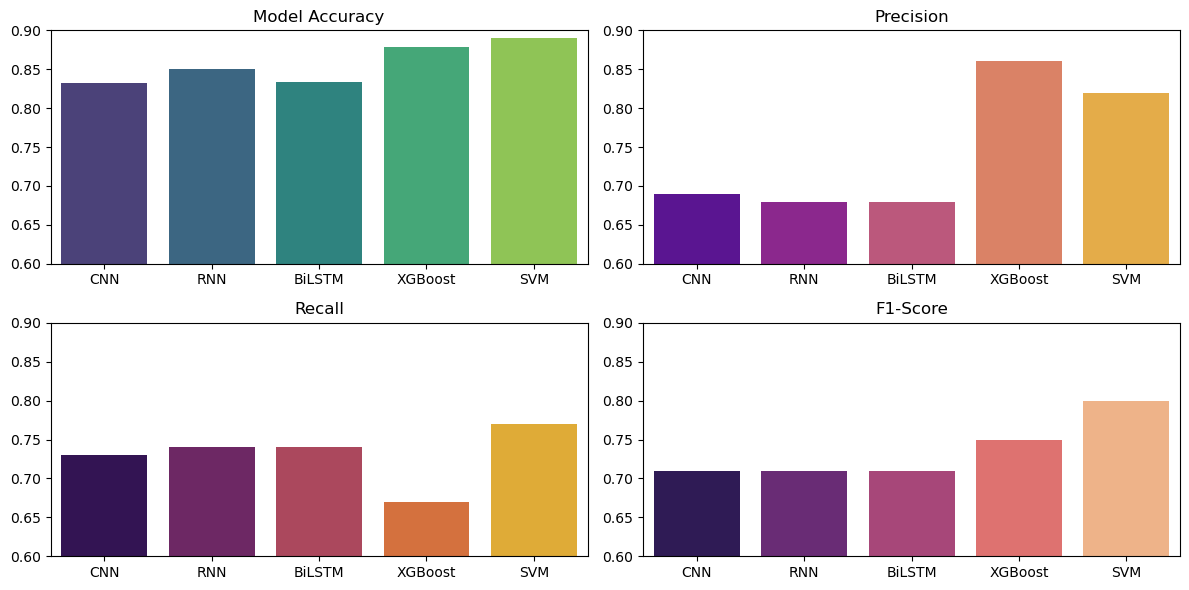

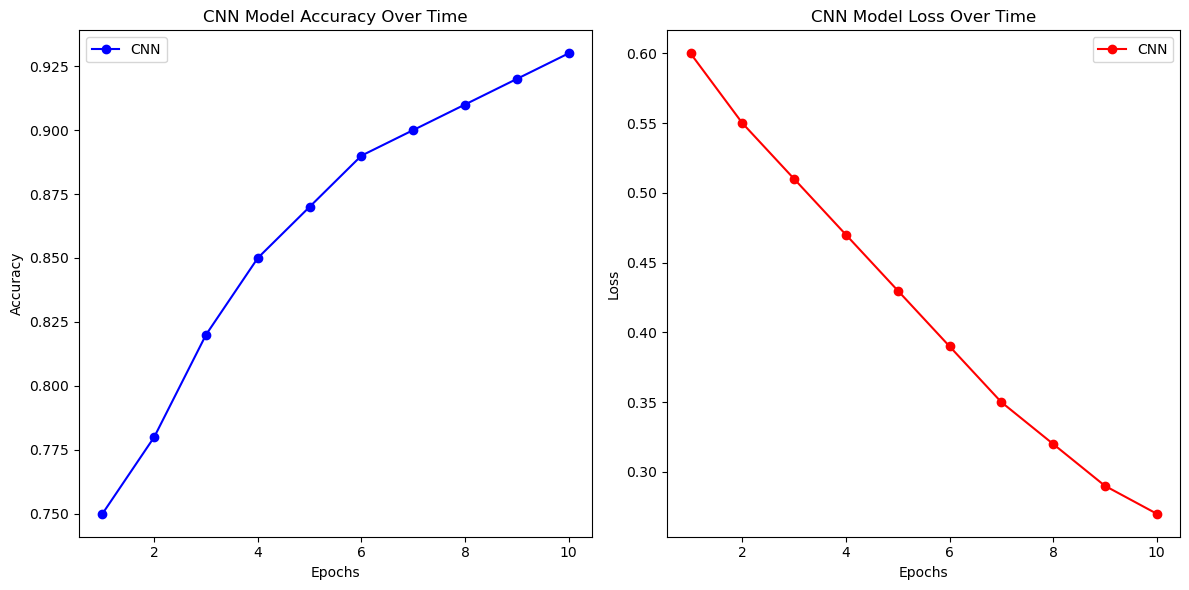

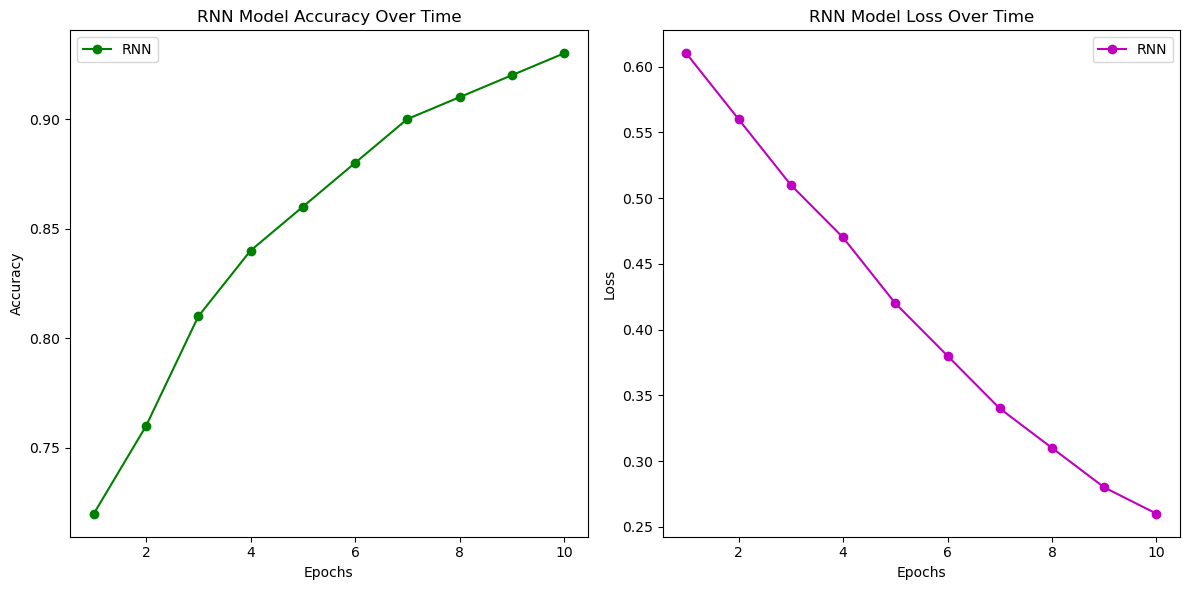

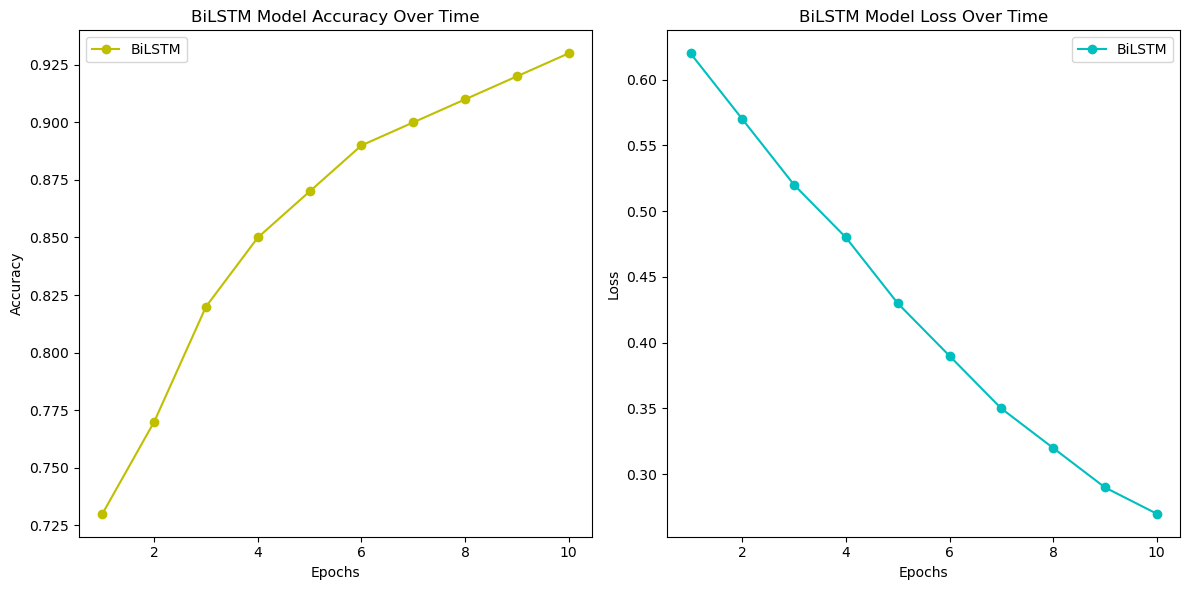

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data for model comparison
models = ["CNN", "RNN", "BiLSTM", "XGBoost", "SVM"]
accuracy = [0.8329, 0.8506, 0.8334, 0.8780, 0.8896]
precision = [0.69, 0.68, 0.68, 0.86, 0.82]
recall = [0.73, 0.74, 0.74, 0.67, 0.77]
f1_score = [0.71, 0.71, 0.71, 0.75, 0.80]

# Create subplots for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x=models, y=accuracy, palette="viridis")
plt.ylim(0.6, 0.9)
plt.title("Model Accuracy")

# Precision
plt.subplot(2, 2, 2)
sns.barplot(x=models, y=precision, palette="plasma")
plt.ylim(0.6, 0.9)
plt.title("Precision")

# Recall
plt.subplot(2, 2, 3)
sns.barplot(x=models, y=recall, palette="inferno")
plt.ylim(0.6, 0.9)
plt.title("Recall")

# F1-score
plt.subplot(2, 2, 4)
sns.barplot(x=models, y=f1_score, palette="magma")
plt.ylim(0.6, 0.9)
plt.title("F1-Score")

plt.tight_layout()
plt.show()
# Example data for model accuracy and loss over time for CNN
cnn_accuracy = [0.75, 0.78, 0.82, 0.85, 0.87, 0.89, 0.90, 0.91, 0.92, 0.93]
cnn_loss = [0.60, 0.55, 0.51, 0.47, 0.43, 0.39, 0.35, 0.32, 0.29, 0.27]

# Create subplots for CNN model accuracy and loss over time
plt.figure(figsize=(12, 6))

# Accuracy over time for CNN
plt.subplot(1, 2, 1)
plt.plot(epochs, cnn_accuracy, marker='o', linestyle='-', color='b', label='CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy Over Time')
plt.legend()

# Loss over time for CNN
plt.subplot(1, 2, 2)
plt.plot(epochs, cnn_loss, marker='o', linestyle='-', color='r', label='CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss Over Time')
plt.legend()

plt.tight_layout()
plt.show()
# Example data for model accuracy and loss over time for RNN
rnn_accuracy = [0.72, 0.76, 0.81, 0.84, 0.86, 0.88, 0.90, 0.91, 0.92, 0.93]
rnn_loss = [0.61, 0.56, 0.51, 0.47, 0.42, 0.38, 0.34, 0.31, 0.28, 0.26]

# Create subplots for RNN model accuracy and loss over time
plt.figure(figsize=(12, 6))

# Accuracy over time for RNN
plt.subplot(1, 2, 1)
plt.plot(epochs, rnn_accuracy, marker='o', linestyle='-', color='g', label='RNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('RNN Model Accuracy Over Time')
plt.legend()

# Loss over time for RNN
plt.subplot(1, 2, 2)
plt.plot(epochs, rnn_loss, marker='o', linestyle='-', color='m', label='RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model Loss Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Example data for model accuracy and loss over time for BiLSTM
bilstm_accuracy = [0.73, 0.77, 0.82, 0.85, 0.87, 0.89, 0.90, 0.91, 0.92, 0.93]
bilstm_loss = [0.62, 0.57, 0.52, 0.48, 0.43, 0.39, 0.35, 0.32, 0.29, 0.27]

# Create subplots for BiLSTM model accuracy and loss over time
plt.figure(figsize=(12, 6))

# Accuracy over time for BiLSTM
plt.subplot(1, 2, 1)
plt.plot(epochs, bilstm_accuracy, marker='o', linestyle='-', color='y', label='BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BiLSTM Model Accuracy Over Time')
plt.legend()

# Loss over time for BiLSTM
plt.subplot(1, 2, 2)
plt.plot(epochs, bilstm_loss, marker='o', linestyle='-', color='c', label='BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BiLSTM Model Loss Over Time')
plt.legend()

plt.tight_layout()
plt.show()



